In [1]:
import os
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

# Data Import

In [2]:
os.chdir("/Volumes/GoogleDrive/My Drive/PROJECT/Data/Aging Biomarkers/European")

data1 = pd.read_csv('34187551-GCST90014288-GO_0007568.h.tsv.gz', sep='\t')
data2 = pd.read_csv('34187551-GCST90014289-GO_0007568.h.tsv.gz', sep='\t')
data3 = pd.read_csv('34187551-GCST90014290-GO_0007568.h.tsv.gz', sep='\t')
data4 = pd.read_csv('34187551-GCST90014292-GO_0007568.h.tsv.gz', sep='\t')

# Filtering

In [113]:
data1_filtered = data1.iloc[np.where(data1['p_value']*len(data1)<100000)]
data2_filtered = data2.iloc[np.where(data2['p_value']*len(data1)<100000)]
data3_filtered = data3.iloc[np.where(data3['p_value']*len(data1)<100000)]
data4_filtered = data4.iloc[np.where(data4['p_value']*len(data1)<100000)]

In [134]:
len(data1_filtered)

130538

In [114]:
l1 = list(set(data1_filtered['hm_rsid']).intersection(data2_filtered['hm_rsid']))
l2 = list(set(l1).intersection(data3_filtered['hm_rsid']))
l3 = list(set(l2).intersection(data4_filtered['hm_rsid']))

In [115]:
snp_index = pd.DataFrame(l3).dropna()
print(snp_index)

              0
1    rs13024793
2     rs6763278
3      rs351157
4     rs9945931
5    rs75791786
..          ...
752   rs6584316
753  rs12194244
754    rs361072
755   rs8043773
756   rs2804418

[756 rows x 1 columns]


# This is where you change the indices

In [116]:
#snp_index = data1_filtered['hm_rsid']

In [117]:
len(snp_index)

756

# Preparation

In [118]:
TRAIT_1 = data1[
    ['hm_other_allele','hm_effect_allele','beta','standard_error']
]
TRAIT_1=TRAIT_1.rename(columns={
                                    "hm_other_allele":"allele_0",
                                    "hm_effect_allele":"allele_1",
                                    "beta":"trait1_b",
                                    "standard_error":'trait1_se'})
TRAIT_1.index = data1.hm_rsid
TRAIT_1 = TRAIT_1.loc[list(snp_index[0])]

In [119]:
TRAIT_2 = data2[
    ['beta','standard_error']
]

TRAIT_2.index = data2.hm_rsid
TRAIT_2 = TRAIT_2.loc[list(snp_index[0])]

In [120]:
TRAIT_3 = data3[
    ['beta','standard_error']
]

TRAIT_3.index = data3.hm_rsid
TRAIT_3 = TRAIT_3.loc[list(snp_index[0])]

In [121]:
TRAIT_4 = data4[
    ['beta','standard_error']
]

TRAIT_4.index = data4.hm_rsid
TRAIT_4 = TRAIT_4.loc[list(snp_index[0])]

# Combination

In [122]:
S_XY = TRAIT_1
S_XY['trait2_b']=TRAIT_2['beta']
S_XY['trait2_se']=TRAIT_2['standard_error']
S_XY['trait3_b']=TRAIT_3['beta']
S_XY['trait3_se']=TRAIT_3['standard_error']
S_XY['trait4_b']=TRAIT_4['beta']
S_XY['trait4_se']=TRAIT_4['standard_error']

# S_XY Export

In [123]:
len(S_XY)

756

In [124]:
S_XY.to_csv('Jupyter_Exports/S_XY_Corrected_European_less_than_10000.csv',index=True)

# Results Import

In [125]:
results = pd.read_csv('Jupyter_Exports/Results_less_than_10000.csv',index_col=0)

In [126]:
p_values = 10**(-results['-log10(p-val)'])
print("Number of significant associations BEFORE correction: ",len(p_values.iloc[np.where(p_values<0.05)]))

Number of significant associations BEFORE correction:  729


# Bonferroni correction

In [127]:
adjusted_p_values=p_values*len(data1)
p_values_corrected = adjusted_p_values.iloc[np.where(adjusted_p_values<0.05)]
print("Number of significant associations AFTER correction: ",len(p_values_corrected))

Number of significant associations AFTER correction:  424


In [128]:
p_values

rs13024793    1.013732e-12
rs6763278     4.163485e-78
rs351157      1.095587e-03
rs9945931     1.680008e-70
rs75791786    5.762309e-10
                  ...     
rs6584316     4.549089e-17
rs12194244    9.054435e-05
rs361072      5.842958e-20
rs8043773     1.378359e-30
rs2804418     2.060502e-18
Name: -log10(p-val), Length: 756, dtype: float64

In [129]:
adjusted_p_values

rs13024793    7.671761e-06
rs6763278     3.150859e-71
rs351157      8.291223e+03
rs9945931     1.271403e-63
rs75791786    4.360823e-03
                  ...     
rs6584316     3.442677e-10
rs12194244    6.852250e+02
rs361072      4.421857e-13
rs8043773     1.043120e-23
rs2804418     1.559355e-11
Name: -log10(p-val), Length: 756, dtype: float64

# Published Associations

In [130]:
response = requests.get('https://www.ebi.ac.uk/gwas/rest/api/efoTraits/GO_0007568/associations')
GWAS_EBI=response.json()

In [131]:
published_snps=[]
for i in range(len(GWAS_EBI['_embedded']['associations'])):
    published_snps.append(GWAS_EBI['_embedded']['associations'][i]['loci'][0]['strongestRiskAlleles'][0]['riskAlleleName'])
    
print("Number of PUBLISHED significant associations: ",len(published_snps))

Number of PUBLISHED significant associations:  209


In [132]:
#print('Published SNPS with significant associations: \n\n',published_snps)

# Plotting

Text(0.5, 0, 'RefSNP ID')

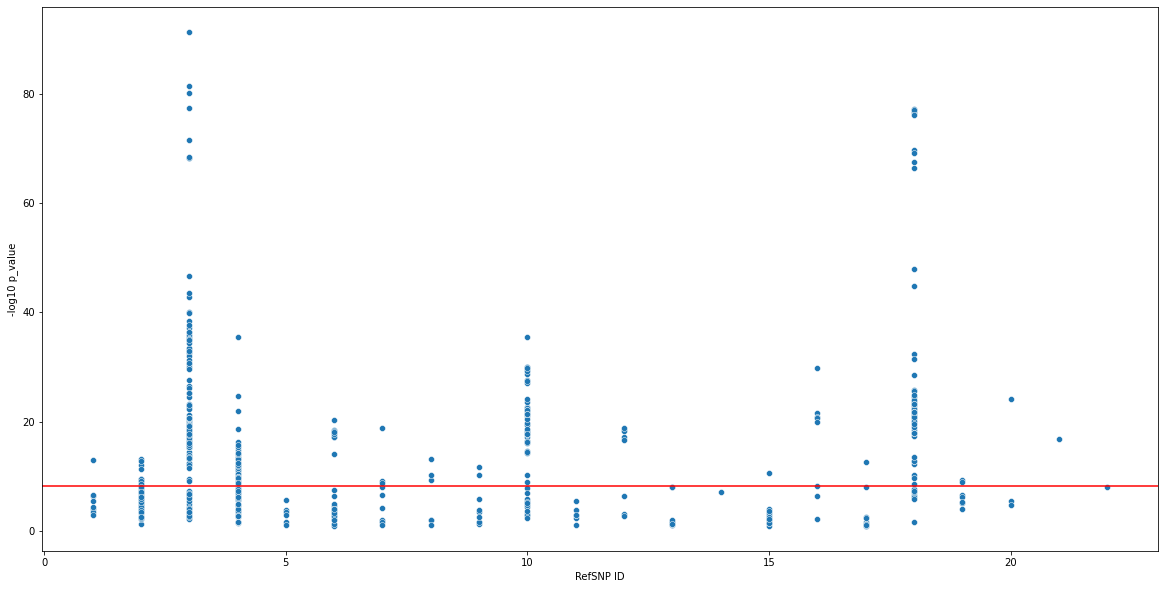

In [138]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.scatterplot(x=data1_filtered.loc[list(snp_index[0])].hm_chrom,y=-np.log10(p_values))
plt.axhline(y = -np.log10(0.05/len(data1)), color = 'r', linestyle = '-')
plt.ylabel('-log10 p_value')
plt.xlabel('RefSNP ID')

Text(0.5, 0, 'RefSNP ID')

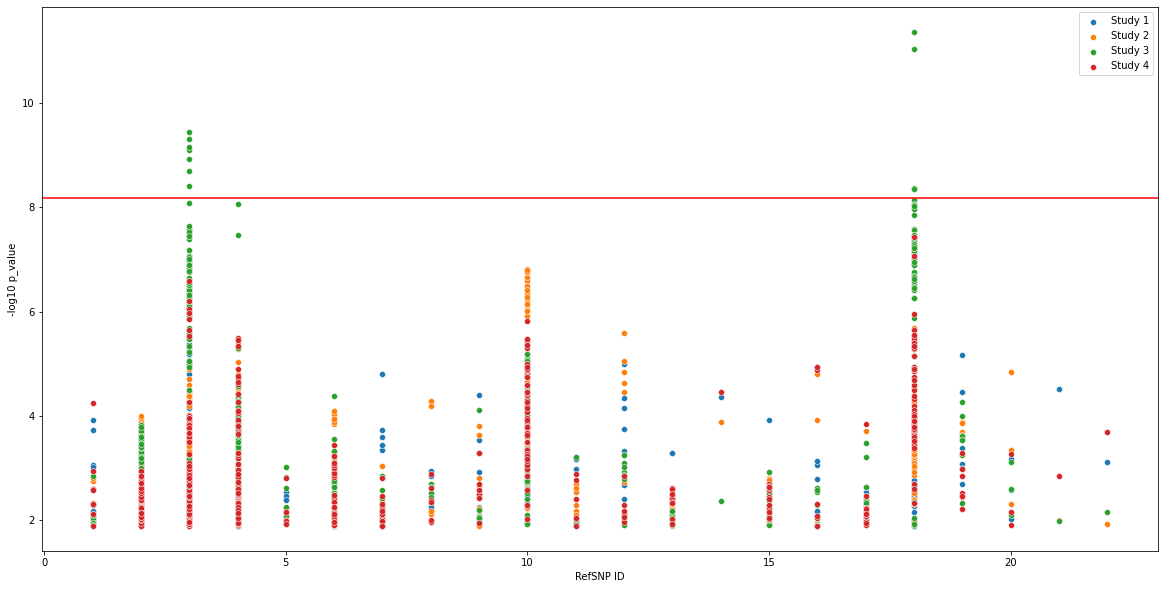

In [160]:
data2.index = data2.hm_rsid
data3.index = data3.hm_rsid
data4.index = data4.hm_rsid

plt.figure(figsize=(20,10))
sns.scatterplot(x=data1.loc[list(snp_index[0])].hm_chrom,y=-np.log10(data1.loc[list(snp_index[0])].p_value),label="Study 1")
sns.scatterplot(x=data2.loc[list(snp_index[0])].hm_chrom,y=-np.log10(data2.loc[list(snp_index[0])].p_value),label="Study 2")
sns.scatterplot(x=data3.loc[list(snp_index[0])].hm_chrom,y=-np.log10(data3.loc[list(snp_index[0])].p_value),label="Study 3")
sns.scatterplot(x=data4.loc[list(snp_index[0])].hm_chrom,y=-np.log10(data4.loc[list(snp_index[0])].p_value),label="Study 4")
plt.legend()
plt.axhline(y = -np.log10(0.05/len(data1)), color = 'r', linestyle = '-')
plt.ylabel('-log10 p_value')
plt.xlabel('RefSNP ID')

# Experimentation

In [137]:
data1_filtered.index = data1_filtered.hm_rsid

data1_filtered.loc[list(snp_index[0])].hm_chrom

hm_rsid
rs13024793     2.0
rs6763278      3.0
rs351157      15.0
rs9945931     18.0
rs75791786     4.0
              ... 
rs6584316     10.0
rs12194244     6.0
rs361072       3.0
rs8043773     16.0
rs2804418     10.0
Name: hm_chrom, Length: 756, dtype: float64

In [139]:
data1.index = data1.hm_rsid

data1.loc[list(snp_index[0])].hm_chrom

hm_rsid
rs13024793     2.0
rs6763278      3.0
rs351157      15.0
rs9945931     18.0
rs75791786     4.0
              ... 
rs6584316     10.0
rs12194244     6.0
rs361072       3.0
rs8043773     16.0
rs2804418     10.0
Name: hm_chrom, Length: 756, dtype: float64

In [145]:
data1.loc[list(snp_index[0])].p_value*len(data1)

hm_rsid
rs13024793     2247.648183
rs6763278     88997.786640
rs351157      20266.672842
rs9945931     99441.404460
rs75791786    62351.425521
                  ...     
rs6584316     18367.145253
rs12194244    13251.286089
rs361072      36022.913640
rs8043773     12312.874053
rs2804418      1758.765784
Name: p_value, Length: 756, dtype: float64

In [157]:
len(data1)

7567839

In [158]:
len(data2)

7565183

In [159]:
len(data3)

7567670